**Part 2. AI Agent 활용 프로젝트**

- Chapter 04. 사전구축 Agent

    - **📒[실습]** Clip 01. LangGraph Supervisor - 자료검색과 코딩 전문가🗒️

## [Prebuilt Langgraph Supervisor](https://github.com/langchain-ai/langgraph-supervisor-py) 사용하기

https://langchain-ai.github.io/langgraph/reference/supervisor/

`pip install langgraph-supervisor`

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

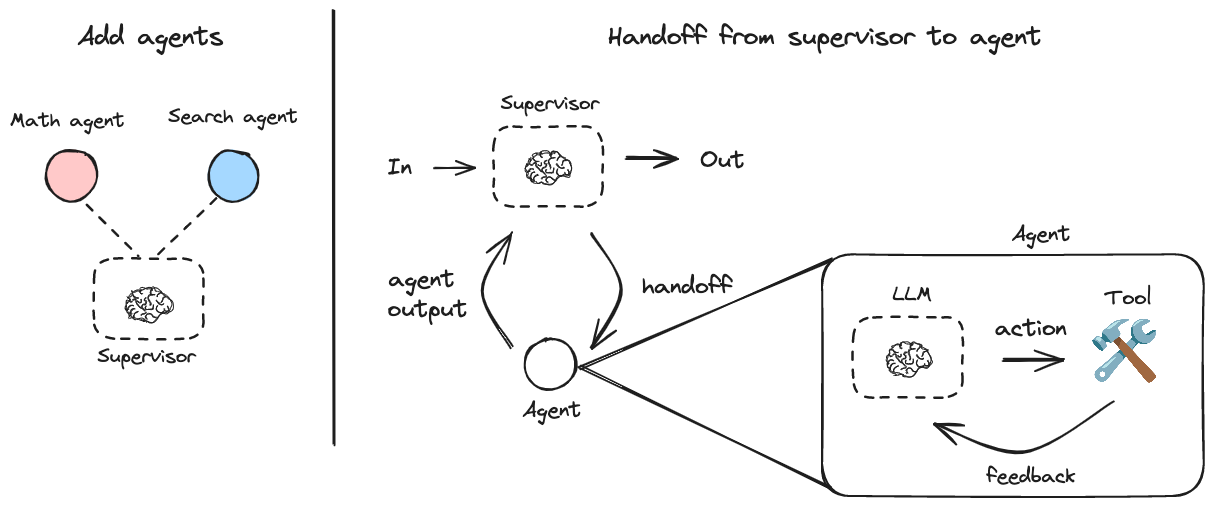

In [2]:
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

model = ChatOpenAI(model="gpt-4o")

# Create specialized agents

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)

# Compile and run
app = workflow.compile()
result = app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "what's the combined headcount of the FAANG companies in 2024?"
        }
    ]
})

In [3]:
for msg in result['messages']:
    msg.pretty_print()

================================ Human Message =================================

what's the combined headcount of the FAANG companies in 2024?
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_research_expert (call_r3VxIo5zpqzjnvmASpEzgFsE)
 Call ID: call_r3VxIo5zpqzjnvmASpEzgFsE
  Args:
================================= Tool Message =================================
Name: transfer_to_research_expert

Successfully transferred to research_expert
================================== Ai Message ==================================
Name: research_expert

Here are the headcounts for each of the FAANG companies in 2024:

1. **Facebook (Meta)**: 67,317 employees
2. **Apple**: 164,000 employees
3. **Amazon**: 1,551,000 employees
4. **Netflix**: 14,000 employees
5. **Google (Alphabet)**: 181,269 employees

To find the combined headcount, you would sum these numbers.
================================== Ai Message =============

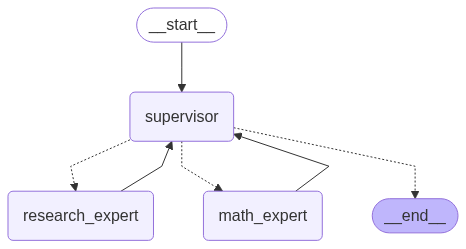

In [4]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 자료 검색 전문 Agent 만들기

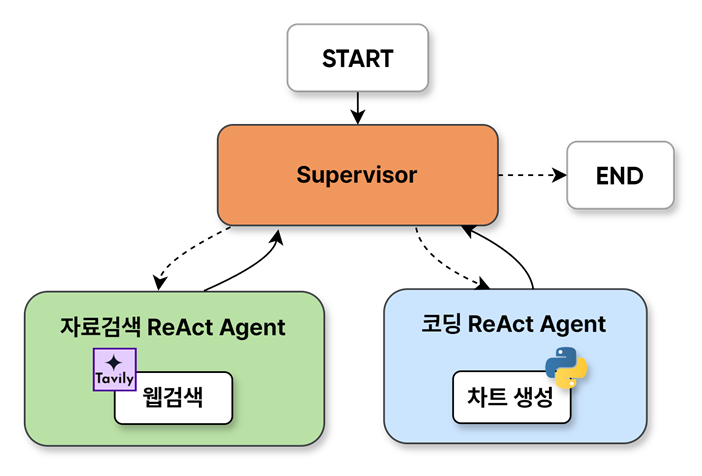

In [4]:
_set_env("TAVILY_API_KEY")

In [5]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults

llm = ChatOpenAI(model="gpt-4o", temperature=0)

search_agent = create_react_agent(
    llm,
    [TavilySearchResults(max_results=5)],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any coding.",
)

## 코딩 전문 Agent 만들기

In [6]:
from typing import Annotated
from langchain_core.tools import tool


@tool
def python_exec_tool(
    code: Annotated[str, "The python code to execute to generate your chart or anything."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = exec(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [7]:
coding_agent = create_react_agent(
    llm,
    [python_exec_tool],
    name="coding_expert",
    prompt="You can only generate python codes. Do not do any search.",
)

In [8]:
graph_builder = create_supervisor(
    [search_agent, coding_agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a research expert and a python coding expert. "
        "For current events, use research_agent. "
        "For coding problems, use coding_agent."
    )
)

graph = graph_builder.compile()

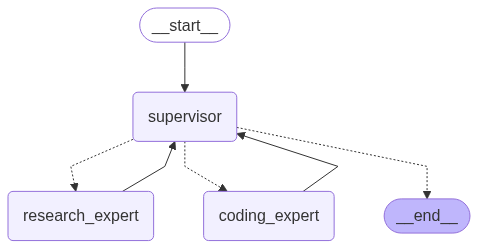

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

테스트 !

In [9]:
for node, chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "2025년 한강에서 열리는 행사에 대해 알려줘."
            }
        ]
    },
    subgraphs=True, 
    stream_mode="updates",
):  
    if(len(node) > 0):
        print("\n===== 👉", node, "=====")
    for state_key, state_value in chunk.items():
        print(f"State: {state_key}, Value: {state_value}")
        for msg in state_value["messages"]:
            msg.pretty_print()


===== 👉 ('supervisor:4bb5c92e-f595-7376-030e-9ba6581d305c',) =====
State: agent, Value: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LhWO5eQab7Mm4GjxCBqKlFeG', 'function': {'arguments': '{}', 'name': 'transfer_to_research_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 112, 'total_tokens': 126, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BbNmY34Ey2Nk7Z0pMV2StwIKuKc0j', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-87448e3f-ec5b-48cd-bf85-af907bdcb03d-0', tool_calls=[{'name': 'transfer_to_research_expert', 'args': {}, 'id': 'call_LhWO5eQab7Mm4GjxCBqKlFeG', 'type': 'tool_call'}], usage_metadata

In [10]:
for node, chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "첫번째 항이 1인 피보나치 수열을 구하는 함수를 파이썬으로 작성해줘. 해당 함수의 10번째 항까지 출력해서 확인해줘."
            }
        ]
    },
    subgraphs=True, 
    stream_mode="updates",
):  
    if(len(node) > 0):
        print("\n===== 👉", node, "=====")
    for state_key, state_value in chunk.items():
        print(f"State: {state_key}, Value: {state_value}")
        for msg in state_value["messages"]:
            msg.pretty_print()


===== 👉 ('supervisor:38ad878f-cb07-99b3-8924-628b01a948fc',) =====
State: agent, Value: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Y7uZbdYJbnlGCp5bf5y7MPMw', 'function': {'arguments': '{}', 'name': 'transfer_to_coding_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 139, 'total_tokens': 153, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BbNoFiLkv85tX5ZJTmqOwk7dAGatt', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-cfa05129-ca64-4faa-8850-35354a1eb8ae-0', tool_calls=[{'name': 'transfer_to_coding_expert', 'args': {}, 'id': 'call_Y7uZbdYJbnlGCp5bf5y7MPMw', 'type': 'tool_call'}], usage_metadata={'i


===== 👉 ('supervisor:21f820e7-6a97-f130-cfa6-77923d25e24c',) =====
State: agent, Value: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_W96VehuZq21bH4kESeiAEdln', 'function': {'arguments': '{}', 'name': 'transfer_to_research_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 161, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-BbNq4G7U1oOMYuZRAV6KnOiLsWLau', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run-bf96b66c-7102-41af-a73f-61ac92805d83-0', tool_calls=[{'name': 'transfer_to_research_expert', 'args': {}, 'id': 'call_W96VehuZq21bH4kESeiAEdln', 'type': 'tool_call'}], usage_metadata

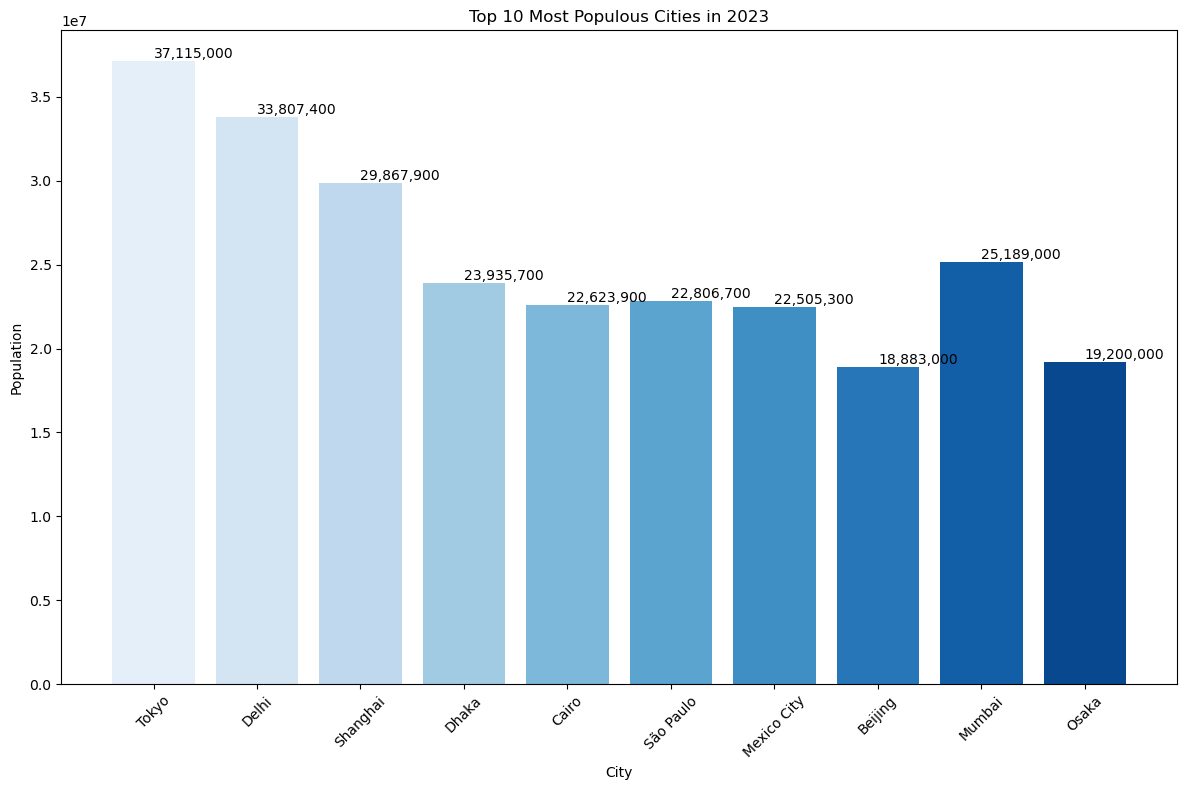


===== 👉 ('coding_expert:01b4e371-1d7f-a739-9d2b-8289a9e3c1aa',) =====
State: tools, Value: {'messages': [ToolMessage(content='Successfully executed:\n\\`\\`\\`python\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Data\ncities = ["Tokyo", "Delhi", "Shanghai", "Dhaka", "Cairo", "São Paulo", "Mexico City", "Beijing", "Mumbai", "Osaka"]\npopulations = [37115000, 33807400, 29867900, 23935700, 22623900, 22806700, 22505300, 18883000, 25189000, 19200000]\n\n# Create a color palette\npalette = sns.color_palette("Blues", len(cities))\n\n# Plot\nplt.figure(figsize=(12, 8))\nbars = plt.bar(cities, populations, color=palette)\n\n# Add labels\nplt.xlabel(\'City\')\nplt.ylabel(\'Population\')\nplt.title(\'Top 10 Most Populous Cities in 2023\')\n\n# Add population labels on top of the bars\nfor bar, population in zip(bars, populations):\n    yval = bar.get_height()\n    plt.text(bar.get_x() + bar.get_width()/2, yval, f\'{population:,}\', va=\'bottom\')  # va: vertical alignment\n\nplt.x

In [11]:
for node, chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": """세계에서 가장 인구가 많은 도시 10곳을 찾아, 도시별 인구수를 나타내는 시각화 코드를 실행해주세요. \n
            인구 수에 비례하여 막대 그래프의 색상을 설정하고, 각 도시의 이름과 인구수를 레이블로 추가해주세요.\n\n"""
            }
        ]
    },
    subgraphs=True, 
    stream_mode="updates",
):  
    if(len(node) > 0):
        print("\n===== 👉", node, "=====")
    for state_key, state_value in chunk.items():
        print(f"State: {state_key}, Value: {state_value}")
        for msg in state_value["messages"]:
            msg.pretty_print()